<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/WoW_Screenshot_OCR_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WoW Screenshot OCR model - TRAINING

  - MODELS
- Text Detector default with CRAFT weights, it should locate and crop texts
- Text Recognizer fine tuned with WoW Fonts, it should recognize characters

  - ASSETS
- WoW fonts : FRIZQT, SKURRI, ARIALN, MORPHEUS
- BG images : Simple WoW images with no UI and text rendered

  - TRAINING
- We will create generators for screenshots and text frames
- We will create datasets to fit Recognizer
- We will fine tune recognizer to be able to read WoW game fonts

  - KERAS_OCR
- Should be use with python 3.9, more info : https://github.com/faustomorales/keras-ocr


## Install


In [1]:
!pip install keras_ocr

import drive.MyDrive.keras_ocr as keras_ocr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import

In [2]:
import zipfile
import datetime
import string
import math
import os
import sys
#import keras_oc€r
import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

import numpy

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)


## Fonts & BGs - Assets needed to be able to generate WoW screenshot with fonts

- Use Drive or import WoW Fonts .TTF in Colab
- Use Drive or import WoW ingame image .jpg with no text and no UI displayed



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
default_dir = sys.path[0] + "/drive/MyDrive/"
fonts_dir = default_dir + "wowfonts/"
bgs_dir = default_dir + "wowbackgrounds/"

fonts = os.listdir(fonts_dir) * 16 # artificial increase set size
fonts = [fonts_dir + font for font in fonts]

backgrounds = os.listdir(bgs_dir) * 16 # artificial increase set size
backgrounds = [bgs_dir +  bg for bg in backgrounds]

 ## Detector Image Generator - Generate a "screenshot" with random text

The first generated text is: CarrierswhomacawsamazonparrotscockatoosAfricangreyslovebirdscockatiels
The first generated validation image (below) contains: T
ampaPolicelargel
yhavebeenhuntedtoextinctionThe


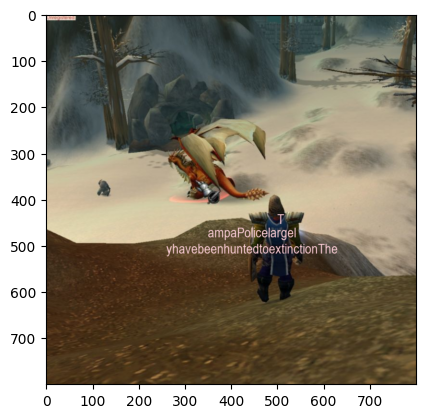

In [8]:
# This is intended to be use for DETECTOR training

alphabet = string.digits + string.ascii_letters
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=800,
        width=800,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts,
        },
        backgrounds=current_backgrounds,
        font_size=(16, 32),
        margin=50,
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See random generated screenshot
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

## Models Defintion - Recognizer and Detector

In [9]:
# Pre trained default weights for both models
recognizer = keras_ocr.recognition.Recognizer()
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)

# Freeze backbone layers
for layer in recognizer.backbone.layers:
    layer.trainable = False

recognizer.compile()

Instructions for updating:
Colocations handled automatically by placer.


Looking for /root/.keras-ocr/crnn_kurapan.h5
Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


## Recognizer Text Frame Generator - Generate a text with WoW font and BG

This image contains: Divinebein


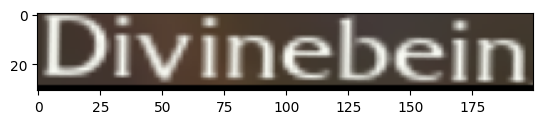

In [10]:
# This is intended to be used for RECOGNIZER training

max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See random generated text frames
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

## Recognizer Train Generator - Create training , validation and test datasets


In [11]:
recognition_batch_size = 8
data_dir = '.'

recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')

recognition_train_generator, recognition_val_generator, recognition_test_generator = [
    recognizer.get_batch_generator(
    image_generator=image_generator,
    batch_size=recognition_batch_size,
    lowercase=True
    ) for image_generator in recognition_image_generators
]


## Callbacks - Save best model and early stop

In [12]:
# Stop iterations regarding to loss value
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

# Saving model at each epoch if values are better than the previous
model_checkpoint = ModelCheckpoint(default_dir+'wow_ocr.h5', monitor='loss', mode='min', save_best_only=True, verbose=1, save_weights_only=True)

## Resume Training - Load recognizer saved weights if any

In [13]:
weights_path = default_dir+"wow_ocr.h5"

if os.path.exists(weights_path):
  recognizer.model.load_weights(weights_path)

## Recognizer Training - Fit

In [ ]:
recognizer.training_model.fit(
    recognition_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    epochs=1000,
    callbacks=[model_checkpoint, early_stop],
    use_multiprocessing=True,
)

# WoW Screenshot OCR Model - PARSING SCREENSHOT TO TEXTE

## Create Pipeline with fine tuned recognizer



In [14]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


## Get Predictions with original screenshots

In [13]:
# Screenshots example
images = [
    keras_ocr.tools.read(url)
    for url in [
        "https://archive.thealphaproject.eu/media/Alpha-Project-Archive/UNSORTED/www_judgehype_com/Galerie%20d-images%20-%20Beta%20screenshots%20-%2020%20octobre%20-%20Mathieu%20Raid%20-%20World%20of%20Warcraft%20-%20JudgeHype%20-%2004-09-2021%2002-20-20/20%20october%2004%20-%2015.jpg",
        "https://archive.thealphaproject.eu/media/Alpha-Project-Archive/Images/Azeroth/Eastern%20Kingdoms/Stranglethorn%20Vale/WoWScrnShot_061904_102357.jpg",
    ]
]

# Results
prediction_groups = pipeline.recognize(images)
# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Plot Results

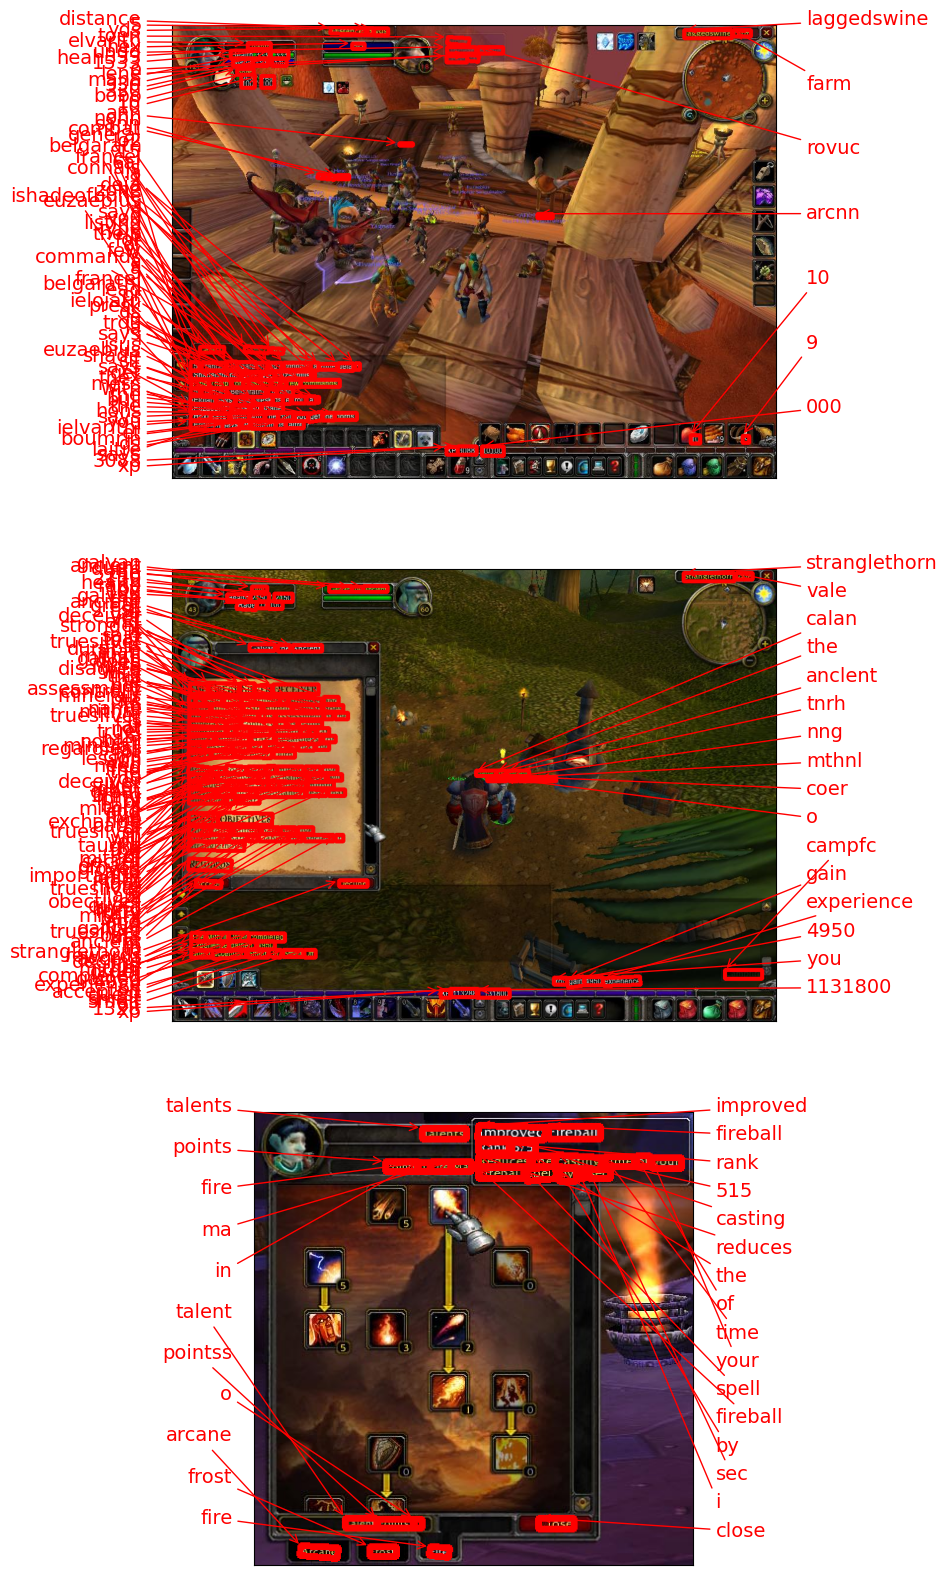

In [14]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)